# Adiabatic state preparation with Bloqade

First, we create a so-called chained $\mathbb{Z}_2$ state of 9 atoms with open boundary conditions, following the [tutorial](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/2.adiabatic/main/#Preparation-of-Ordered-States-in-1D).

In [4]:
using Bloqade
using PythonCall
using KrylovKit
using SparseArrays

In [5]:
plt = pyimport("matplotlib.pyplot");

In [6]:
# specify the adiabatic pulse sequence for Rabi frequency
total_time = 3.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]);

In [7]:
# create detuning sequence
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

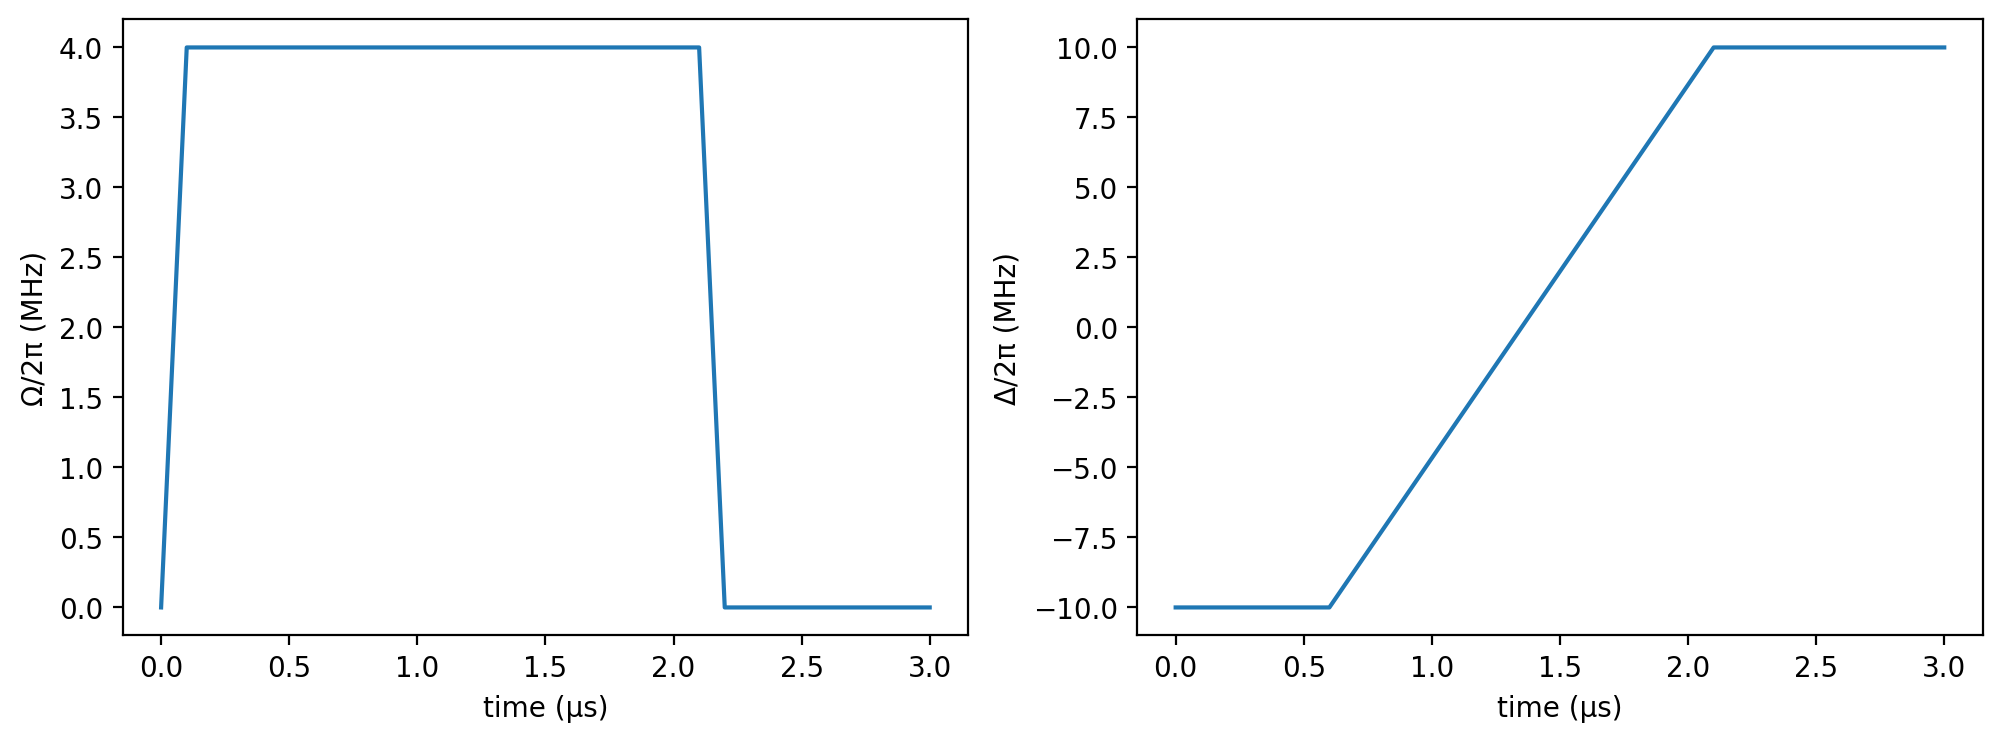

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

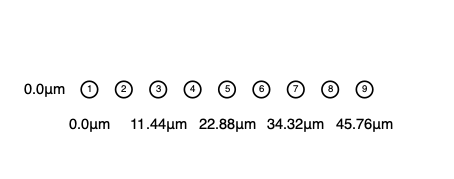

In [9]:
# generate positions of 1D atom chain
nsites = 9
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

In [10]:
# time-dependent Hamiltonian
h = rydberg_h(atoms; Δ, Ω)

nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


In [11]:
# start all atoms in ground state and choose an ODE solver
reg = zero_state(9);
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

In [12]:
densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...);

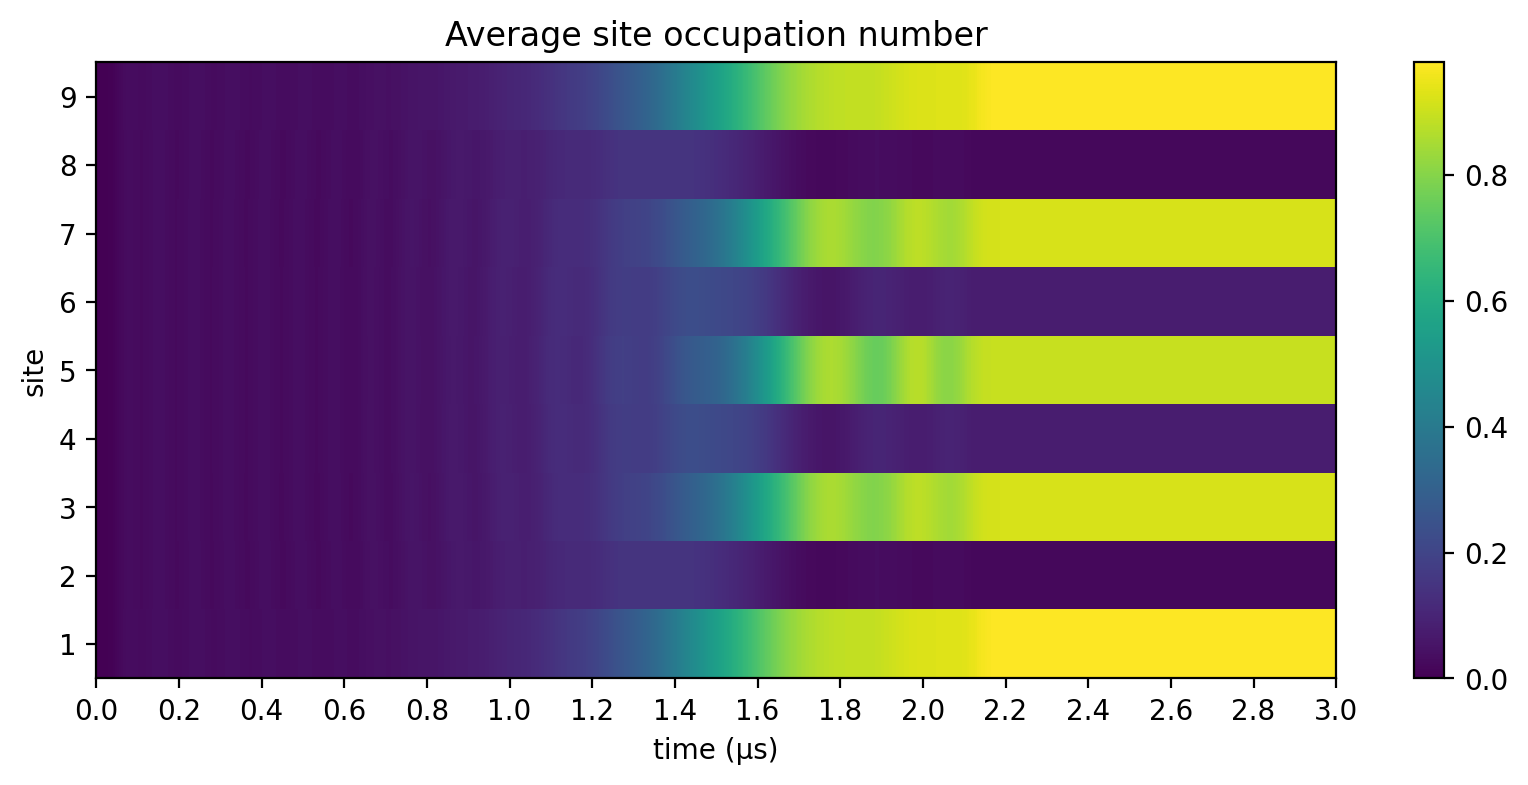

In [13]:
fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
plt.title("Average site occupation number")
fig

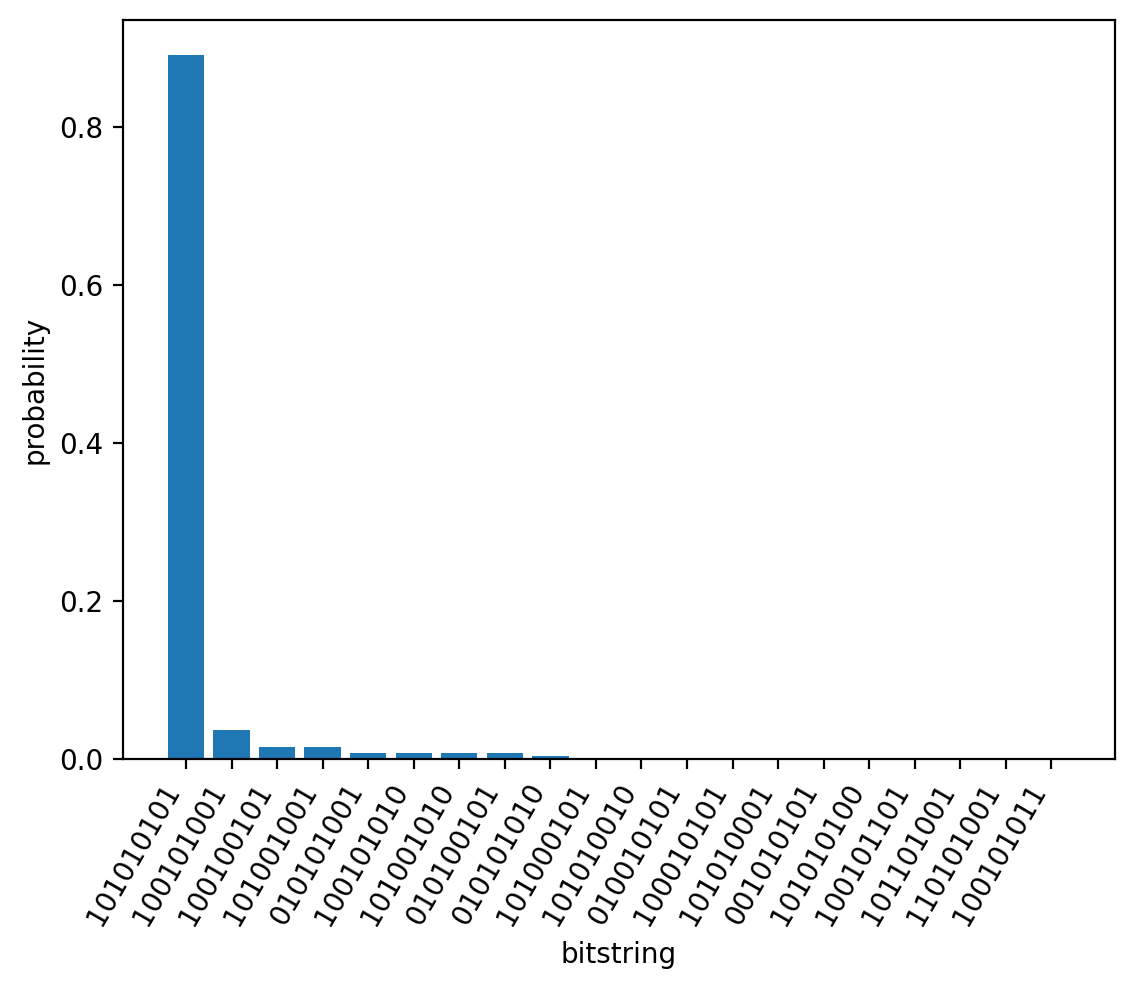

In [14]:
# view the final state via measurement
bitstring_hist(reg; nlargest = 20)

Next we calculate $\langle\sigma^x_i\rangle$.

In [15]:
for i = 1:9
    print(expect(put(9, i=>X), reg))
    print("\n")
end

-0.014005680828171488 + 0.0im
-5.076229173033649e-5 + 0.0im
0.06032536438076344 + 0.0im
-0.0014638632283657735 + 5.421010862427522e-20im
0.07716399042973178 + 0.0im
-0.001463863228397239 + 0.0im
0.060325364382150026 - 3.469446951953614e-18im
-5.0762291653281156e-5 + 0.0im
-0.014005680829032058 + 0.0im


Evaluating $E_0$ and $E_1$. From the histogram above, we can see that the ground state is $|101010101\rangle$.

In [23]:
hamiltonian = h |> attime(total_time) 

nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] 2π ⋅ 0.0 ⋅ ∑ σ^x_i
└─ [-] 2π ⋅ 10.0 ⋅ ∑ n_i


In [24]:
# create the ground state and measure the energy E_0 = <H>_0
groundstate = product_state(bit"101010101")
E_0 = expect(hamiltonian,groundstate)

-304.3661971975399 + 0.0im

Theoretically the first excited state would be either $|100100101\rangle$ or $|101001001\rangle$ since the hamiltonian prefers excited states to be farther apart.

In [25]:
# create one of the first excited states and measure the energy E1
firstexcited = product_state(bit"100100101")
E_1 = expect(hamiltonian, firstexcited)

-248.47089534253737 + 0.0im

In [26]:
E_1-E_0

55.89530185500254 + 0.0im

The energy difference $E_1-E_0=55.895\text{ MHz}$.  
To confirm, we can compute the eigen values of the Hamiltonian by diagonalizing it.

In [27]:
h_m = mat(hamiltonian)


512×512 SparseMatrixCSC{ComplexF64, Int64} with 511 stored entries:
⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄

In [29]:
vals, vecs, info = KrylovKit.eigsolve(h_m, 2, :SR)
vals[2]-vals[1]

55.89530185500243

: 